<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
This notebook is designed specially for the module

ET5003 - MACHINE LEARNING APPLICATIONS 

Instructor: Enrique Naredo
###ET5003_GaussianProcesses

© All rights reserved to the author, do not share outside this module.


## Introduction

The concept of [Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process) is named after Carl Friedrich Gauss because it is based on the notion of the Gaussian distribution (normal distribution). 

* Gaussian processes can be seen as an infinite-dimensional generalization of multivariate normal distributions.

* Gaussian processes are useful in statistical modelling, benefiting from properties inherited from the normal distribution. 

* For example, if a random process is modelled as a Gaussian process, the distributions of various derived quantities can be obtained explicitly. 

* Such quantities include the average value of the process over a range of times and the error in estimating the average using sample values at a small set of times. 

* While exact models often scale poorly as the amount of data increases, multiple approximation methods have been developed which often retain good accuracy while drastically reducing computation time. 

**Acknowledgement**

This notebook is refurbished taking source code from Alessio Benavoli's webpage and from the libraries numpy, GPy, pylab, and pymc3.

## Libraries

In [1]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# https://pypi.org/project/GPy/
!pip install gpy

     |████████████████████████████████| 959 kB 26.3 MB/s 
     |████████████████████████████████| 71 kB 11.0 MB/s 
  Created wheel for gpy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565123 sha256=b42ea8d44613a3f70a022b735173c80664337c1c5c8d309aa79f2acd2ced9baa
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=d1cd53b1d279b00254a6e092f9ca899c05e49be78a4805117f7a4240ce1ef226
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built gpy paramz


In [3]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
import scipy as sp
from keras.models import Sequential
from keras.layers import Dense
%matplotlib inline

## Data generation
Generate data from a nonlinear function and use a Gaussian Process to sample it.

In [4]:
# seed the legacy random number generator
# to replicate experiments
seed = None
#seed = 7
np.random.seed(seed)

In [5]:
# Gaussian Processes
# https://gpy.readthedocs.io/en/deploy/GPy.kern.html
# Radial Basis Functions
# https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
# kernel is a function that specifies the degree of similarity 
# between variables given their relative positions in parameter space
kernel = GPy.kern.RBF(input_dim=1,lengthscale=0.15,variance=0.2)
print(kernel)

  rbf.         |  value  |  constraints  |  priors
  variance     |    0.2  |      +ve      |        
  lengthscale  |   0.15  |      +ve      |        


In [6]:
# number of samples
num_samples_train = 250 
num_samples_test = 200

# intervals to sample
a, b, c = 0.2, 0.6, 0.8
# points evenly spaced over [0,1]
interval_1 = np.random.rand(int(num_samples_train/2))*b - c
interval_2 = np.random.rand(int(num_samples_train/2))*b + c

X_new_train = np.sort(np.hstack([interval_1,interval_2])) 
X_new_test  = np.linspace(-1,1,num_samples_test)

X_new_all = np.hstack([X_new_train,X_new_test]).reshape(-1,1)

# vector of the means
μ_new = np.zeros((len(X_new_all)))
# covariance matrix
C_new = kernel.K(X_new_all,X_new_all)

# noise factor
noise_new = 0.1

# generate samples path with mean μ and covariance C
TF_new = np.random.multivariate_normal(μ_new,C_new,1)[0,:]
y_new_train = TF_new[0:len(X_new_train)] + np.random.randn(len(X_new_train))*noise_new
y_new_test = TF_new[len(X_new_train):] + np.random.randn(len(X_new_test))*noise_new
TF_new = TF_new[len(X_new_train):]

In this example, first generate a nonlinear functions and then generate noisy training data from that function.

The constrains are:
* Training samples $x$ belong to either interval $[-0.8,-0.2]$ or $[0.2,0.8]$.
* There is not data training samples from the interval $[-0.2,0.2]$. 
* The goal is to evaluate the extrapolation error outside in the interval  $[-0.2,0.2]$.

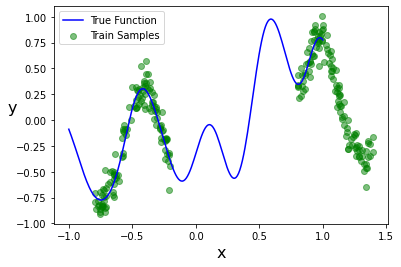

In [7]:
# plot 
pb.figure()
pb.plot(X_new_test,TF_new,c='b',label='True Function',zorder=100)
# training data
pb.scatter(X_new_train,y_new_train,c='g',label='Train Samples',alpha=0.5)
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
pb.legend()
pb.savefig("New_data.pdf")

## Gaussian process


They are equivalent to a NN with infinite hidden-units.

In [8]:
# quadratic polynomial kernel
def QPK(x_1, x_2, α, degree):
    xx1 = x_1**np.arange(0,deg+1)
    xx2 = x_2**np.arange(0,deg+1)
    return np.linalg.multi_dot([xx1,np.diag(α),xx2.T])

In [9]:
# sample points
x = np.linspace(-1,1,50).reshape(-1,1)

# degree of the polynomial kernel
deg = 2

# parameters
α = np.ones(deg+1)
Q = QPK(x, x, α, deg)
Z = np.zeros(len(x))

# build a quadratic polynomial function
f1 = np.random.multivariate_normal(Z,Q,15)

In [10]:
# show shape
f1.shape

(15, 50)

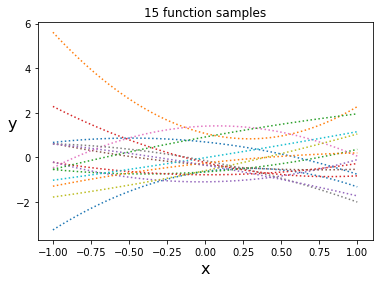

In [11]:
# plot function samples
pb.plot(x,f1.T,':')
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
pb.title("15 function samples")
pb.savefig("poly2.pdf")

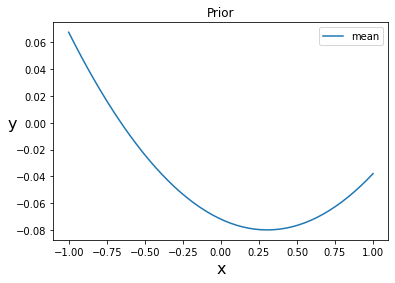

In [12]:
# plot prior
pb.plot(x,np.mean(f1,axis=0),label='mean')
pb.legend()
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
pb.title("Prior")
pb.savefig("quadratic_polynomial.pdf")

In [13]:
# build a larger quadratic polynomial function
f2 = np.random.multivariate_normal(Z,Q,15000)

In [14]:
# show shape
f2.shape

(15000, 50)

In [15]:
# square exponential kernel
def SEK(x_1, x_2, lengthscale, sigma_f):
    x1a = x_1**2/lengthscale**2
    x1b = x_1/lengthscale**2
    x2a = x_2**2/lengthscale**2
    A = np.sum(x1a, 1).reshape(-1, 1)
    B = np.sum(x2a, 1)
    C = 2 * np.dot(x1b, x_2.T)
    sqdist = A + B - C
    return sigma_f**2 * np.exp(-0.5 * sqdist)

In [16]:
# sample points
x3 = np.linspace(-1,1,40).reshape(-1,1)
lengthscale = np.ones(1)*0.3

# build a square exponential function
sigma_f3 = 1
Z3 = np.zeros(len(x3))
E3 = SEK(x3,x3, lengthscale, sigma_f3)
f3 = np.random.multivariate_normal(Z3, E3, 15)

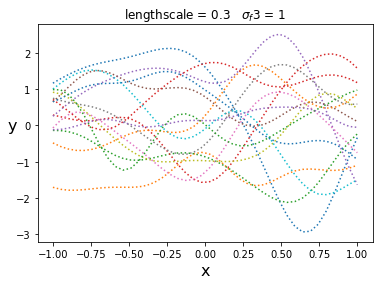

In [17]:
# plot family of functions
pb.plot(x3,f3.T,':')
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
pb.title("lengthscale = "+str(lengthscale[0]) + "   " + "$\sigma_f3$ = "+str(sigma_f3) )
pb.savefig("RBF_03.pdf")

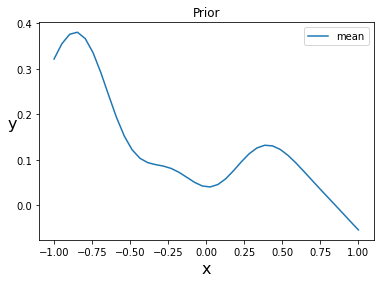

In [18]:
# plot average
pb.plot(x3,np.mean(f3,axis=0),label='mean')
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
pb.legend()
pb.title("Prior")
pb.savefig("rbf.pdf")

In [19]:
def posterior_predictive(X_s, X_train, y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8, K=SEK):
    ''' 
    Compute sufficient statistics of the GP posterior predictive distribution 
    from m training, data X_train, y_train, and n new inputs X_s. 
    Args: X_s: new input locations (n x d)
          X_train: training locations (m x d) 
          y_train: training targets (m x 1) 
          l: Kernel length parameter
          sigma_f: Kernel vertical variation parameter
          sigma_y: Noise parameter 
          K: Kernel [SEK]
    Returns: Posterior mean vector (n x d) and covariance matrix (n x n).
    '''

    K0 = K(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = K(X_train, X_s, l, sigma_f)
    K_ss = K(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = np.linalg.inv(K0)
    mu_s = K_s.T.dot(K_inv).dot(y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [20]:
# compute posterior
xa = np.array([[0,0.3,-0.8,0.2,0.5,-0.4,-0.6]]).reshape(-1,1)
xa1 = np.linspace(-1,1,50).reshape(-1,1)
E4 = SEK(xa,xa, lengthscale, sigma_f3)
ya = np.random.multivariate_normal(np.zeros(len(xa)),E4,1).T
xb = xa[0:4,:]
yb = ya[0:4,:]

# get mean vector and covariance matrix
mu_A, cov_A = posterior_predictive(xa1, xb, yb, l=lengthscale, sigma_f=sigma_f3, sigma_y=1e-8, K=SEK)

## Posterior after i observations

(-3.75, 3.75)

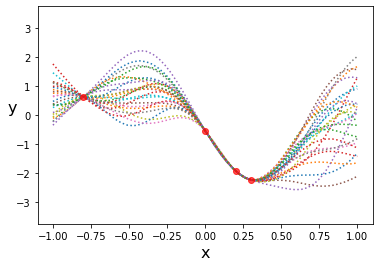

In [21]:
# posterior plot
f_postA = np.random.multivariate_normal(mu_A[:,0], cov_A, 25)
pb.plot(xa1,f_postA.T,':')
pb.scatter(xb, yb,c='r',alpha=0.7,Zorder=100)
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
pb.savefig("posterior.pdf")
pb.ylim([-3.75,3.75])

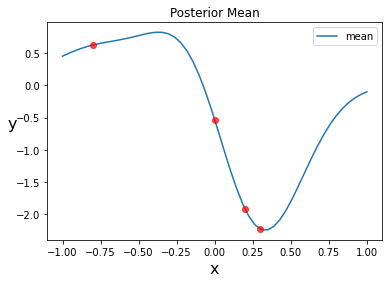

In [22]:
# Average
f_postB = np.random.multivariate_normal(mu_A[:,0], cov_A, 14550)
pb.xlabel("x", fontsize=16)
pb.ylabel("y", fontsize=16,rotation=0)
pb.plot(xa1, np.mean(f_postB,axis=0), label='mean')
pb.scatter(xb, yb,c='r', alpha=0.7, Zorder=100)
pb.legend()
pb.title("Posterior Mean")
pb.savefig("PosteriorMean.pdf")

## 50 observations

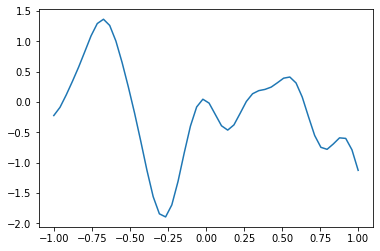

In [23]:
# 
lengthscale=0.15
np.random.seed(42)
x5 = np.linspace(-1,1,50).reshape(-1,1)
x5a = np.linspace(-1,1,50).reshape(-1,1)
y5 = np.random.multivariate_normal(np.zeros(len(x)),SEK(x5,x5, lengthscale, sigma_f3),1).T
pb.plot(x5,y5)

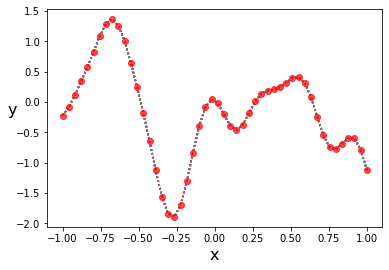

In [24]:
# 
mu, cov = posterior_predictive(x5a, x5, y5, l=lengthscale, sigma_f=sigma_f3, sigma_y=1e-5, K=SEK)
f_post5 = np.random.multivariate_normal(mu[:,0], cov, 25)
pb.plot(x5a,f_post5.T,':')
pb.scatter(x5, y5,c='r',alpha=0.7,Zorder=100)
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
pb.savefig("om.pdf")

In [35]:
# 
np.random.seed(7)
xa_6 = np.array([[0,0.3,-0.8]]).reshape(-1,1)
xa1_6 = np.linspace(-1,1,50).reshape(-1,1)
ya_6 = np.random.multivariate_normal(np.zeros(len(xa_6)),SEK(xa_6,xa_6, lengthscale, sigma_f3),1).T
ya_6 = ya_6 + np.random.randn(ya_6.shape[0],ya_6.shape[1])*0.2
xb_6 = xa_6[0:3,:]
yb_6 = ya_6[0:3,:]
mu6, cov6 = posterior_predictive(xa1_6, xb_6, yb_6, l=lengthscale, sigma_f=sigma_f3, sigma_y=0.2, K=SEK)

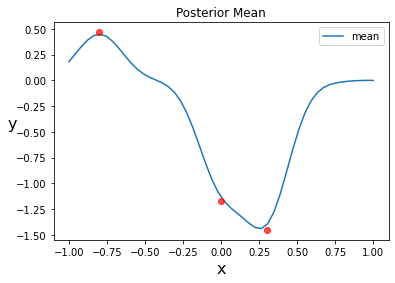

In [36]:
# 
f_post6 = np.random.multivariate_normal(mu6[:,0], cov6, 14550)
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
pb.plot(xa1_6,np.mean(f_post6,axis=0),label='mean')
pb.scatter(xb_6, yb_6,c='r',alpha=0.7,Zorder=100)
pb.legend()
pb.title("Posterior Mean")
pb.savefig("PosteriorMean.pdf")

In [37]:
# 
np.random.seed(7)
xa_6 = np.array([[0,0.3,-0.8]]).reshape(-1,1)
xa1_6 = np.linspace(-1,1,50).reshape(-1,1)
ya_6 = np.random.multivariate_normal(np.zeros(len(xa_6)),SEK(xa_6,xa_6, lengthscale, sigma_f3),1).T
ya_6 = ya_6 + np.random.randn(ya_6.shape[0],ya_6.shape[1])*0.2
xb_6 = xa_6[0:3,:]
yb_6 = ya_6[0:3,:]
mu6, cov6 = posterior_predictive(xa1_6, xb_6, yb_6, l=lengthscale, sigma_f=sigma_f3, sigma_y=0.2, K=SEK)

In [38]:
#
xa_7 = np.linspace(-1,1,50).reshape(-1,1)
xa1_7 = np.linspace(-1,1,50).reshape(-1,1)
ya_7 = np.random.multivariate_normal(np.zeros(len(xa_7)),SEK(xa_7,xa_7, lengthscale, sigma_f3),1).T
ya_7 = ya_7 + np.random.randn(ya_7.shape[0],ya_7.shape[1])*0.2

mu7, cov7 = posterior_predictive(xa1_7, xa_7, ya_7, l=lengthscale, sigma_f=sigma_f3, sigma_y=0.2)

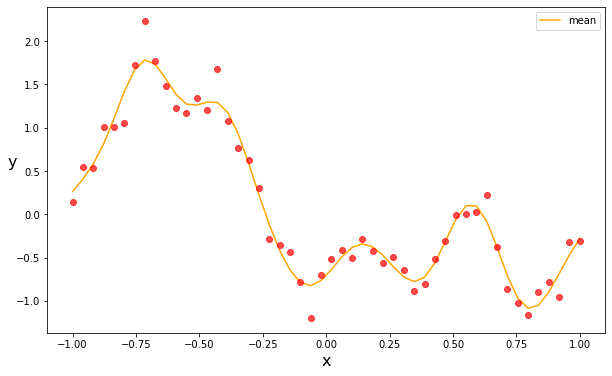

In [39]:
# 
pb.figure(figsize=(10,6))
f_post7 = np.random.multivariate_normal(mu7[:,0], cov7, 500)
pb.plot(xa_7,np.mean(f_post7,axis=0),color='orange',label='mean')
pb.scatter(xa_7, ya_7,c='r',alpha=0.7,Zorder=100)
pb.xlabel("x",fontsize=16)
pb.ylabel("y",fontsize=16,rotation=0)
pb.legend()
pb.savefig("PosteriorMean7.pdf")

In [40]:
print(f_post7)

[[ 0.3705889   0.46622727  0.60456174 ... -0.56220941 -0.37741836
  -0.27419116]
 [ 0.4530277   0.49661816  0.63692139 ... -0.5784463  -0.2368358
   0.06892484]
 [ 0.51057436  0.51292287  0.59577956 ... -0.58810103 -0.41327362
  -0.2931984 ]
 ...
 [ 0.14648788  0.30487459  0.48993665 ... -0.70542519 -0.46594071
  -0.20299716]
 [ 0.29988338  0.46127737  0.66666938 ... -0.50394311 -0.22694991
  -0.04213602]
 [ 0.33945783  0.3566686   0.52445139 ... -0.72961062 -0.63546124
  -0.57759369]]
